#Read Kafka Data in Batch Mode#

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Configure Kafka bootstrap servers
kafka_bootstrap_servers = "bore.pub:9093"

# Read Kafka data in batch mode
kafka_df = (spark.read
            .format("kafka")
            .option("kafka.bootstrap.servers", kafka_bootstrap_servers)
            .option("subscribe", "music_streaming_events")
            .option("startingOffsets", "earliest")
            .load())

# Cast the Kafka message value to a string
raw_df = kafka_df.select(col("value").cast("STRING").alias("message"))

# Verify the data by showing the first record
raw_df.show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|message                                                                                                                                                                                                                                      |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"user_id": "18", "artist": "Leona Lewis", "genre": "Pop", "listen_timestamp": "2025-05-17T20:07:00Z", "title": "Bleeding Love", "year": 2008, "sales": 29.316, "streams": 9.512, "downloads": 10.05, "radio_plays": 16.324, "rating": 1.076}|
+---------------------------------------

#Parse JSON and Scale Streams#

In [0]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Define the schema for the JSON data
schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("artist", StringType(), True),
    StructField("genre", StringType(), True),
    StructField("listen_timestamp", StringType(), True),
    StructField("title", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("sales", DoubleType(), True),
    StructField("streams", DoubleType(), True),
    StructField("downloads", DoubleType(), True),
    StructField("radio_plays", DoubleType(), True),
    StructField("rating", DoubleType(), True)
])

# Parse the JSON data into structured columns
parsed_df = raw_df.withColumn("data", from_json(col("message"), schema)).select("data.*")

# Filter out records with null user_id to ensure data quality
parsed_df = parsed_df.filter(col("user_id").isNotNull())

# Scale the streams column (multiply by 100 million)
parsed_df = parsed_df.withColumn("streams", col("streams") * 1e8)

#Compute and Visualize Average Streams per Genre#


Plot saved to /tmp/avg_streams_per_genre_batch.png


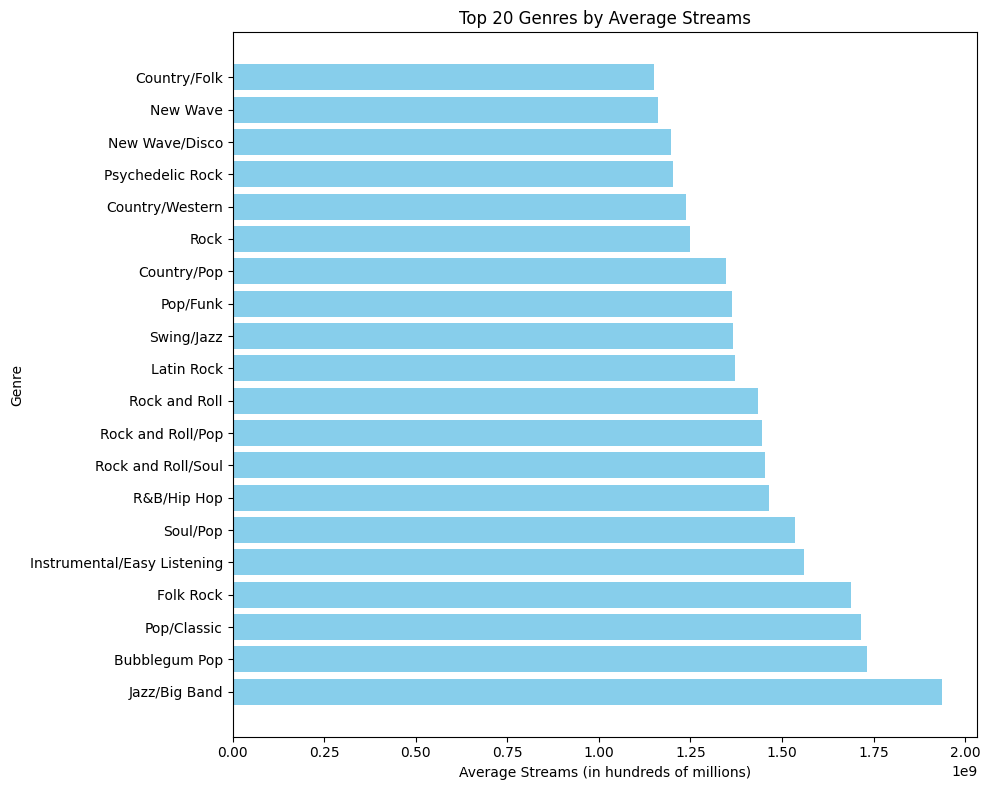

                          genre  avg_streams (billions)
0                 Jazz/Big Band                1.936000
1                 Bubblegum Pop                1.731800
2                   Pop/Classic                1.715900
3                     Folk Rock                1.687600
4   Instrumental/Easy Listening                1.560800
5                      Soul/Pop                1.536600
6                   R&B/Hip Hop                1.464700
7            Rock and Roll/Soul                1.454300
8             Rock and Roll/Pop                1.445600
9                 Rock and Roll                1.435436
10                   Latin Rock                1.370800
11                   Swing/Jazz                1.366600
12                     Pop/Funk                1.364500
13                  Country/Pop                1.347933
14                         Rock                1.249467
15              Country/Western                1.237100
16             Psychedelic Rock                1

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = parsed_df.select("genre", "streams").toPandas()

# Compute the average streams per genre and name the column 'avg_streams'
avg_streams_df = pandas_df.groupby("genre")["streams"].mean().reset_index(name="avg_streams")

# Sort by avg_streams and take the top 20 genres for better visualization
avg_streams_df = avg_streams_df.sort_values("avg_streams", ascending=False).head(20)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(avg_streams_df["genre"], avg_streams_df["avg_streams"], color="skyblue")
plt.xlabel("Average Streams (in hundreds of millions)")
plt.ylabel("Genre")
plt.title("Top 20 Genres by Average Streams")
plt.tight_layout()

# Save the plot to a temporary directory
try:
    plt.savefig("/tmp/avg_streams_per_genre_batch.png")
    print("Plot saved to /tmp/avg_streams_per_genre_batch.png")
except Exception as e:
    print(f"Failed to save plot: {e}")

# Display the plot in Databricks
display(plt.gcf())

# Close the plot to free memory
plt.close()

# Format the avg_streams column to display in billions and reset the index
avg_streams_df["avg_streams"] = avg_streams_df["avg_streams"] / 1e9  # Convert to billions
avg_streams_df = avg_streams_df.rename(columns={"avg_streams": "avg_streams (billions)"})
avg_streams_df = avg_streams_df.reset_index(drop=True)

# Print the average streams table
print(avg_streams_df)